# Работа №4

__Предыдущие разделы__
- Sampling Data
- Range
- Range-Doppler

Для упрощения работы и анализа радиолокационных данных существует множество открытых библиотек на github. Однако есть наиболее оконченная такая как ```openradar```. Вся дальнейшая работа основана на наработках данного репозитория.
```python 
!pip install openradar # Библиотека для работы с радаром
import mmwave as mm # импорт библиотеки для работы с радаром
```
Ссылка на github репозиторий: [OpenRadar on github](https://github.com/PreSenseRadar/OpenRadar)  
Ссылка на докумкентацию модуля: [Welcome to the mmwave docs!](https://openradar.readthedocs.io/en/latest/)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import requests
import io

response = requests.get('https://github.com/PreSenseRadar/OpenRadar/blob/master/Presense%20Applied%20Radar/assets/doppler_example_1.npy?raw=true');
response.raise_for_status();
doppler_example_1 = io.BytesIO(response.content);

## Вступление - Как Мы можем сделать Лучше?

<img src = "https://github.com/PreSenseRadar/OpenRadar/blob/master/Presense%20Applied%20Radar/assets/protractor.png?raw=true" alt = "drawing" width = "350" align = 'right'>

К сожалению, с нынешним оборудованием, с которым мы экспериментируем, мы уже быстро приближаемся к пределу. Мы уже извлекли две ключевые части информации о дальности и допплере с нашего радара. Вы можете начать думать, что мы просто не можем сделать ничего другого. Однако давайте немного углубимся в теорию и вернемся к тому, почему мы вообще смогли собрать эту информацию. Мы смогли получить дальность действия, поняв, что наши передаваемые электромагнитные волны будут отражаться от цели. Выборка нескольких точек этого возврата позволила бы нам квантовать то, что находится на разных расстояниях относительно радара. Доплер был похож в том смысле, что единственное, что мы добавили к нашей логике, - это отправка нескольких сигналов чириканья. Каждый из этих чипов делал снимки с близким расстоянием во времени, так что приемник радара мог "видеть" микродвижения объектов и преобразовывать их в показания скорости. Итак, теперь я спрашиваю вас, что мы можем сейчас сделать лучше?

Ну, чтобы направить вас в правильном направлении, это, вероятно, будет иметь какое-то отношение к множеству чего-то, основанного на моих вынужденных подсказках в предыдущем абзаце. Если вам все еще нужна помощь, чтобы что-то придумать, что, если я скажу вам, что вы не должны ограничивать себя текущим оборудованием?..

Ха! Бьюсь об заклад, некоторые из вас только что подумали о том, чтобы склеить несколько радаров вместе, что звучит просто нелепо. Тем не менее, такое мышление - это именно то, что нам нужно, чтобы двигаться вперед. Давайте просто настроим его так, чтобы в итоге он стал немного более осуществимым, чем раньше.

## Что такое MIMO?

Ранее мы кратко упоминали, что радар, который мы использовали (или предполагали, что мы использовали), имеет только __1 TX__ и __1 RX__, или 1 передатчик и 1 приемник. Это не всегда так, даже в некоторых из прошлых упражнений, которые мы выполняли. Потешаясь над мыслью о физическом склеивании нашего радара с копией самого себя, мы можем провести простую математику и сказать, что наш радар теперь имеет (1 + 1) TX и (1 + 1) RX. Отлично! Однако что это значит, что мы должны получить двойное разрешение диапазона? Нет ... мы уже доказали в модуле диапазона, что разрешение диапазона зависит от полосы пропускания сигнала. Чтобы по-настоящему понять, что мы только что сделали, и ценность этого, давайте сначала узнаем о том, что называется MIMO.

MIMO - это сокращение от Multiple Input - Множественный вывод, и это именно то, на что это похоже. Фактически, склеив наши радары, мы технически могли бы создать радар MIMO. В такого рода модели мы теперь можем использовать тот факт, что у нас есть 2 TX (несколько выходов), которые посылают две разные электромагнитные волны, и каждая из них будет приниматься 2 RX (несколько входов). Но подождите, раньше каждый из наших TX сопоставлялся бы с одним RX, так не портит ли это все и не дает ли нам избыточные данные? На самом деле, это хорошая вещь, и мы не просто принимаем сигнал и наивно дублируем его. Фактически, мы фиксируем новую "перспективу" одного и того же сигнала с каждым RX, и это важно. Допустим, один из наших TX отправил сигнал, который попал в объект, и вскоре после этого он должен был быть принят обоими нашими RX. Остановка. Нам нужно быть очень осторожными в том, как мы описываем следующие несколько шагов в этом процессе.

## Угол падения

Если бы мы описали это, не задумываясь, мы могли бы сказать "и затем оба RX получили сигнал", что скрывает суть, которую я пытаюсь донести. В каком порядке RX принимал сигнал (RX1 RX2 или наоборот)? Сколько времени потребовалось последнему, чтобы получить его? Все это имеет значение. По правде говоря, нам действительно не нужно было говорить о MIMO прямо сейчас, завершая этот модуль, но они хорошо связаны, и вы скоро поймете почему. Подумайте об информации, которую мы получаем, зная, что было первым и как долго. Попробуйте нарисовать это событие, а именно нарисуйте TX, который мы использовали, 2 RX, объект и сигнал между всем. Помните, что даже при том, что сигнал распространяется быстро, он все равно должен распространяться с постоянной скоростью . Выясните, что вы можете сказать, зная, что тот или иной RX получил сигнал первым. Как насчет случая, когда они получают сигнал одновременно? Может быть, ваш рисунок выглядит примерно так...

<img src = "https://github.com/PreSenseRadar/OpenRadar/blob/master/Presense%20Applied%20Radar/assets/simple_aoa.png?raw=true" alt = "drawing" width = "350" align = 'center'>

Все, что находится слева от радара, следует правилу, согласно которому сначала его получает RX 1, а затем RX 2. Это происходит в обратном порядке для любого объекта на правой стороне радара. К настоящему времени, я думаю, вы должны быть в состоянии соединить точки и увидеть, что, "склеивая" радары вместе, мы можем получить угол, под которым приходит волна. А именно, теперь мы можем **точно определить, где находится объект в новом измерении**. В терминологии радиолокации это новое измерение называется **азимут**, причудливый термин для обозначения угла. Наконец-то мы можем выразить словами то, что вы видите на картинке. Любой объект перед радаром заставит сигнал вернуться и попасть на приемники в определенном порядке. Время зависит сначала от угла объекта относительно радара (назовем это $ \theta$), а затем от расстояния между каждым RX (назовем это $l$). Если мы предположим, что входящий сигнал состоит из примерно параллельных лучей, математика становится ясной, и дополнительная длина пути $\Delta d$ упрощается до $l\cdot sin(\theta)$. Хотя это может быть трудно решить напрямую, мы можем еще раз положиться на фазы волн в каждом RX, чтобы предоставить больше информации. Оказывается, что точная разность фаз между двумя соответствующими сигналами на каждом RX пропорциональна этому члену $\Delta d$. Использование БПФ позволит извлечь приблизительный угол прихода нашего сигнала.

В коде мы рассмотрим, как использовать БПФ для измерения азимута...

# Обработка информации об Азимуте

***

## Шаг 1 - Дальность БПФ

Опять же, давайте получим информацию о нашем наборе, чтобы получить некоторое представление о том, на что мы смотрим. Мы уже делали это несколько раз, так что я не буду вас утомлять. Что вы, возможно, захотите иметь в виду, так это то, что мы добавили новое измерение в наши данные, поэтому есть некоторые незначительные изменения.

In [ ]:
# ####################### # Метаданные
num_chirps = 128;         # Количество ЛЧМ в кадре
num_samples = 128;        # Количество отсчетов АЦП на ЛЧМ

num_tx = 2;               # Число передающих антенн
num_rx = 4;               # Число приемных антенн
num_vx = num_tx * num_rx; # Число виртуальных антенн

In [ ]:
''' ДАННЫЕ ДЛЯ ПРИМЕРА '''
# Чтение информации одного кадра
frame = np.load(doppler_example_1);
# Приведение к нужному виду данных
frame.real = frame.real.astype(np.int16);
frame.imag = frame.imag.astype(np.int16);

# Формирование кадра
# frame = chirpData[:num_samples, :num_chirps].T;

print(f'Форма кадра: {frame.shape}');

Форма кадра: (128, 8, 128)


In [ ]:
range_plot = np.fft.fft(frame, axis = 2);

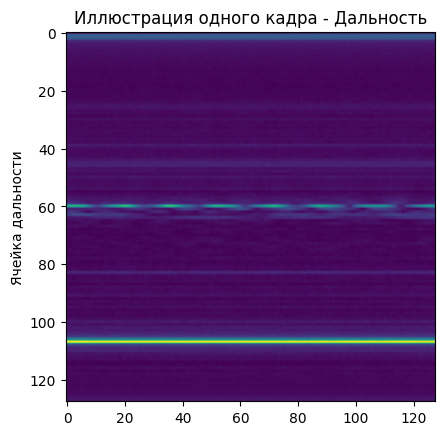

In [ ]:
# Визуализация данных
plt.imshow(np.abs(range_plot.sum(1)).T);
plt.ylabel('Ячейка дальности');
plt.title('Иллюстрация одного кадра - Дальность');
plt.show();

## Шаг 2 - Доплеровский БПФ

Мы также можем использовать знания, полученные из последнего модуля, и извлекать доплеровскую информацию из данных радара. Вы тоже должны знать, как это сделать.

In [ ]:
range_doppler = np.fft.fft(range_plot, axis = 0);
range_doppler = np.fft.fftshift(range_doppler, axes = 0);

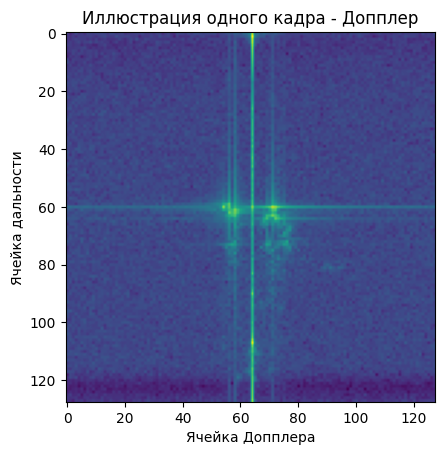

In [ ]:
# Визуализация данных
plt.imshow(np.log(np.abs(range_doppler).T).sum(1));
plt.xlabel('Ячейка Допплера');
plt.ylabel('Ячейка дальности');
plt.title('Иллюстрация одного кадра - Допплер');
plt.show();

## Шаг 3 - Азимутальный БПФ

In [ ]:
num_angle_bins = 64;

In [ ]:
padding = ((0,0), (0,num_angle_bins-range_doppler.shape[1]), (0,0));
range_azimuth = np.pad(range_doppler, padding, mode = 'constant');
range_azimuth = np.fft.fft(range_azimuth, axis = 1);
range_azimuth = range_azimuth;

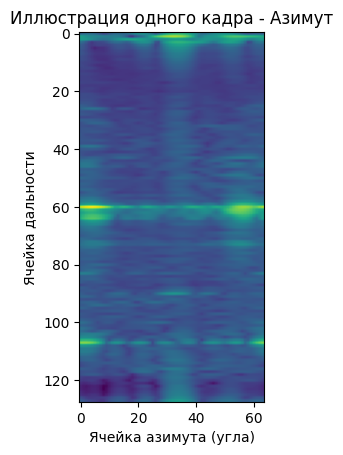

In [ ]:
# Визулизация данных
plt.imshow(np.log(np.abs(range_azimuth).sum(0).T));
plt.xlabel('Ячейка азимута (угла)');
plt.ylabel('Ячейка дальности');
plt.title('Иллюстрация одного кадра - Азимут');
plt.show();

# Дополнительно

***

## Подведение итогов

Этот модуль завершает наше изучение того, какую полезную информацию предлагает радар. В дополнение к дальности и допплеру, мы теперь знаем основы того, как мы можем использовать радар для определения **Угла прибытия**. Короче говоря, обратное рассеяние объекта может быть проанализировано, чтобы найти небольшую разницу во времени прибытия в один RX по сравнению с другим. Однако мы также узнали, что это означает, что невозможно получить эту информацию без **по крайней мере 2 RX**. Напротив, мы получаем **дополнительное угловое разрешение, добавляя больше RX (и виртуальных антенн)**. Поскольку физически становится все труднее добавлять все больше и больше RX, мы можем прибегнуть к добавлению **дополнительного TX, а также RX**. Это создает специальную модель, называемую **массивом с несколькими входами и несколькими выходами**, имитирующую **виртуальные антенны**, которые заменяют наш RX. Например, при 2 TX и 4 RX у нас есть 8 виртуальных антенн. Добавив еще один TX, мы теперь получаем 12 виртуальных антенн, позволяющих нам получить еще большее разрешение.

## С нетерпением жду

После завершения всех базовых модулей вы узнали, как начать использовать радар в реальном мире. Вы могли бы бросить сейчас ... или вы могли бы начать изучать более продвинутые методы. Где-то по ходу дела вы, возможно, заметили, что я на самом деле не показал вам, как сделать что-либо полезное с извлеченными нами данными. Также может показаться, что все запито. Это. То, что ждет нас впереди, увлекательно, и пока мы будем говорить о новых темах, таких как **шум** и **удаление шума**, даже о продвинутых математических способах улучшения этого модуля AOA, называемого **формирование луча**, и о многом другом (осмелюсь сказать **ML / DL**). Я призываю вас изучить больше. Таким образом, вы можете научиться создавать свой собственный конвейер, чтобы, как мы надеемся, выполнить какую-то существенную задачу и решить какую-то реальную проблему. Я уверяю вас, что все эти вещи более сложны, чем просто принятие еще одного БПФ.